In [1]:
%load_ext lab_black
%load_ext pycodestyle_magic
%flake8_on -i E203,E501 -m 119
%load_ext tensorboard

In [2]:
from __future__ import annotations
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import scipy.signal

import gym
from gym.spaces import Discrete, Box
import gnwrapper

import numpy as np
import matplotlib.pyplot as plt

from abc import ABCMeta, abstractmethod
from copy import deepcopy
import time

# Define Network

In [3]:
def mlp(
    sizes: List,
    activation=tf.keras.activations.relu,
    output_activation=tf.keras.activations.linear,
):
    inputs = tf.keras.Input(shape=sizes[0])
    x = layers.Dense(sizes[1], activation=activation)(inputs)

    for i in range(2, len(sizes) - 1):
        x = layers.Dense(sizes[i], activation=activation)(x)

    outputs = layers.Dense(sizes[-1], activation=output_activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
model = mlp(sizes=[156, 256, 128, 64, 4])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 156)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               40192     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 81,604
Trainable params: 81,604
Non-trainable params: 0
_________________________________________________________________


In [5]:
class Actor:
    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distriubtion(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distirbution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):
    def __init__(
        self,
        obs_dim,
        act_dim,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return tfp.distributions.Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)

    def __call__(self, obs, act):
        pi = self._distribution(obs)
        logp = self._log_prob_from_distribution(pi, act)
        return pi, logp

    @property
    def nn(self):
        return self.logits_net


class MLPGaussianActor(Actor):
    def __init__(
        self,
        obs_dim,
        act_dim,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = tf.convert_to_tensor(log_std)
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = tf.exp(self.log_std)
        return tfp.distributions.Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        logp = pi.log_prob(act)
        return tf.reduce_sum(logp, axis=-1)

    def __call__(self, obs, act):
        pi = self._distribution(obs)
        logp = self._log_prob_from_distribution(pi, act)
        return pi, logp

    @property
    def nn(self):
        return self.mu_net


class MLPCritic:
    def __init__(
        self, obs_dim, hidden_sizes=(64, 64), activation=tf.keras.activations.relu
    ):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return tf.squeeze(self.v_net(obs), -1)

    def __call__(self, obs):
        return self.forward(obs)

    @property
    def nn(self):
        return self.v_net


class MLPActorCritic:
    def __init__(
        self,
        observation_space,
        action_space,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):

        obs_dim = observation_space.shape[0]

        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(
                obs_dim, action_space.shape[0], hidden_sizes, activation
            )
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(
                obs_dim, action_space.n, hidden_sizes, activation
            )

        self.v = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        pi = self.pi._distribution(obs)
        a = pi.sample()
        logp_a = self.pi._log_prob_from_distribution(pi, a)
        v = self.v.forward(obs)
        return a.numpy()[0], v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [6]:
env_name = "CartPole-v0"
hidden_sizes = (64, 128)

env = gym.make(env_name)
observation_space = env.observation_space
action_space = env.action_space
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

activation = tf.keras.activations.elu

In [7]:
obs = env.reset()
obs = obs.reshape(1, obs_dim)
print("obs:", obs)
print("")

actor = MLPCategoricalActor(obs_dim, act_dim, hidden_sizes, activation)
predict = actor.logits_net(obs)
pi = actor._distribution(obs)
act = pi.sample()
logp = actor._log_prob_from_distribution(pi, act)
call_pi, call_logp = actor(obs, act)
print("MLPCategoricalActor predict:", predict)
print("MLPCategoricalActor act:", act)
print("MLPCategoricalActor logp:", logp)
print("MLPCategoricalActor callable logp:", call_logp)
print("")

actor = MLPGaussianActor(obs_dim, act_dim, hidden_sizes, activation)
predict = actor.mu_net(obs)
log_std = actor.log_std
pi = actor._distribution(obs)
act = pi.sample()
logp = actor._log_prob_from_distribution(pi, act)
call_pi, call_logp = actor(obs, act)

print("MLPGaussianActor predict:", predict)
print("MLPGaussianActor log_std:", log_std)
print("MLPGaussianActor act:", act)
print("MLPGaussianActor logp:", logp)
print("MLPGaussianActor callable logp:", call_logp)
print("")

critic = MLPCritic(obs_dim, hidden_sizes, activation)
v = critic.forward(obs)
nn_v = critic.nn(obs)
call_v = critic(obs)
print("MLPCritic v:", v)
print("MLPCritic nn v:", nn_v)
print("MLPCritic callable v:", call_v)
print("")

ac = MLPActorCritic(observation_space, action_space, hidden_sizes, activation)
a, v, logp = ac.step(obs)
act = ac.act(obs)
call_pi, call_logp = ac.pi(obs, act)
call_v = ac.v(obs)

print("MLPActorCritic a:", a)
print("MLPActorCritic v:", v)
print("MLPActorCritic logp:", logp)
print("MLPActorCritic act:", act)
print("MLPActorCritic call_logp:", call_logp)
print("MLPActorCritic call_v:", call_v)

print("MLPActorCritic pi net trainable:", tf.shape(ac.pi.nn.trainable_weights[0]))
print("MLPActorCritic v net trainable:", tf.shape(ac.v.nn.trainable_weights[0]))

obs: [[-0.01423626 -0.00587504 -0.03016989  0.00583231]]

MLPCategoricalActor predict: tf.Tensor([[-0.00204483  0.00252295]], shape=(1, 2), dtype=float32)
MLPCategoricalActor act: tf.Tensor([0], shape=(1,), dtype=int32)
MLPCategoricalActor logp: tf.Tensor([-0.6954337], shape=(1,), dtype=float32)
MLPCategoricalActor callable logp: tf.Tensor([-0.6954337], shape=(1,), dtype=float32)

MLPGaussianActor predict: tf.Tensor([[-0.00997275 -0.00553665]], shape=(1, 2), dtype=float32)
MLPGaussianActor log_std: tf.Tensor([-0.5 -0.5], shape=(2,), dtype=float32)
MLPGaussianActor act: tf.Tensor([[ 0.09606624 -0.05976318]], shape=(1, 2), dtype=float32)
MLPGaussianActor logp: tf.Tensor([-0.85715616], shape=(1,), dtype=float32)
MLPGaussianActor callable logp: tf.Tensor([-0.85715616], shape=(1,), dtype=float32)

MLPCritic v: tf.Tensor([-0.00091859], shape=(1,), dtype=float32)
MLPCritic nn v: tf.Tensor([[-0.00091859]], shape=(1, 1), dtype=float32)
MLPCritic callable v: tf.Tensor([-0.00091859], shape=(1,), 

# Utils

In [8]:
class Util:
    def discount_cumsum(x, discount):
        """
        magic from rllab for computing discounted cumulative sums of vectors.
        input:
            vector x,
            [x0,
             x1,
             x2]
        output:
            [x0 + discount * x1 + discount^2 * x2,
             x1 + discount * x2,
             x2]
        """
        return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

    def statistics_scalar(x):
        x = np.array(x, dtype=np.float32)
        global_sum, global_n = np.sum(x), len(x)
        mean = global_sum / global_n

        global_sum_sq = np.sum((x - mean) ** 2)
        std = np.sqrt(global_sum_sq / global_n)

        return mean, std

    def combined_shape(length, shape=None):
        if shape is None:
            return (length,)
        return (length, shape) if np.isscalar(shape) else (length, *shape)


class Dataset:
    def __init__(self, data_map: dict, shuffle=True) -> None:
        self.data_map = data_map
        self.shuffle = shuffle
        self.n_samples = next(iter(data_map.values())).shape[0]
        self._next_id = 0
        if self.shuffle:
            self.shuffle_dataset()

    def shuffle_dataset(self):
        perm = np.arange(self.n_samples)
        np.random.shuffle(perm)

        for key in self.data_map:
            self.data_map[key] = self.data_map[key][perm]

    def next_batch(self, batch_size: int):
        if self._next_id >= self.n_samples:
            self._next_id = 0
            if self.shuffle:
                self.shuffle_dataset()

        cur_id = self._next_id
        cur_batch_size = min(batch_size, self.n_samples - self._next_id)
        self._next_id += cur_batch_size

        data_map = dict()
        for key in self.data_map:
            data_map[key] = self.data_map[key][cur_id : cur_id + cur_batch_size]
        return data_map

    def iterate_once(self, batch_size: int):
        """
        generator that iterates over the dataset
        :param batch_size: (int) the size of the batch
        :return: (dict) a batch of the input data of size 'batch_size'
        """
        if self.shuffle:
            self.shuffle_dataset()

        while self._next_id <= self.n_samples - batch_size:
            yield self.next_batch(batch_size)
        self._next_id = 0

    def subset(self, num_elements: int, shuffle=True):
        data_map = dict()
        for key in self.data_map:
            data_map[key] = self.data_map[key][:num_elements]
        return Dataset(data_map, shuffle)

In [9]:
class Plotter:
    def plot(self, epoch_return: int):
        iteration = range(len(epoch_return))
        plt.plot(iteration, epoch_return)
        plt.ylabel("Avg Return")
        plt.xlabel("Iterations")


class Render:
    def play_one_episode(self, env: env, agent: Agent, batch_size: int, render: bool):
        batch_obs, batch_acts, batch_weights, batch_rets, batch_lens = (
            [],
            [],
            [],
            [],
            [],
        )
        obs_dim = env.observation_space.shape[0]

        obs = env.reset()
        done = False
        ep_rews = []

        while True:
            if render:
                env.render()

            batch_obs.append(obs.copy())

            act, v, logp = agent.ac.step(obs.reshape(1, obs_dim))

            obs, rew, done, _ = env.step(act)

            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                batch_weights += list(self.reward_to_go(ep_rews))

                obs, done, ep_rews = env.reset(), False, []

                if len(batch_obs) > batch_size:
                    break

        if render:
            env.close()
        return batch_obs, batch_acts, batch_weights

    def play_one_episode_continuous(
        self, env: env, agent: Agent, batch_size: int, render: bool
    ):
        batch_obs, batch_acts, batch_weights, batch_rets, batch_lens = (
            [],
            [],
            [],
            [],
            [],
        )
        obs_dim = env.observation_space.shape[0]

        obs = env.reset()
        done = False
        ep_rews = []

        while True:
            if render:
                env.render()

            batch_obs.append(obs.copy())

            act = agent.ac.act(obs.reshape(1, obs_dim))

            obs, rew, done, _ = env.step(act)

            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                batch_weights += list(self.reward_to_go(ep_rews))

                obs, done, ep_rews = env.reset(), False, []

                if len(batch_obs) > batch_size:
                    break

        if render:
            env.close()
        return batch_obs, batch_acts, batch_weights

    def reward_to_go(self, rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i + 1] if i + 1 < n else 0)
        return rtgs

In [10]:
class Agent(metaclass=ABCMeta):
    @abstractmethod
    def apply_loss(self):
        """ apply gradient to update policy """
        pass

    @abstractmethod
    def train(self):
        """ interact with environment and collect samples """
        pass


class BCAgent(metaclass=ABCMeta):
    @abstractmethod
    def pretrain(self):
        """ pretrain agent """
        pass

# Reinforce

In [14]:
class Reinforce(Agent):
    def __init__(self, env, policy, optimizer, **kwargs):
        self.env = env
        assert isinstance(
            env.observation_space, Box
        ), "This example only works for envs with continuous state spaces."
        assert isinstance(
            env.action_space, Discrete
        ), "This example only works for envs with discrete action spaces."
        self.obs_dim = env.observation_space.shape[0]
        self.n_acts = env.action_space.n

        self.policy = policy
        self.optimizer = optimizer

    def get_policy(self, obs):
        """ action distribution"""
        logits = self.policy(obs)
        return tfp.distributions.Categorical(logits=logits)

    def get_action(self, obs):
        """ sample from action distribution"""
        return self.get_policy(obs).sample()

    def compute_loss(self, obs, act, weights):
        logp = self.get_policy(obs).log_prob(act)
        loss = -(logp * weights)
        return tf.math.reduce_mean(loss)

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def apply_gradients(self, batch_obs, batch_acts, batch_weights):
        with tf.GradientTape() as tape:
            batch_loss = self.compute_loss(
                obs=tf.convert_to_tensor(batch_obs, dtype=tf.float32),
                act=tf.convert_to_tensor(batch_acts, dtype=tf.int32),
                weights=tf.convert_to_tensor(batch_weights, dtype=tf.float32),
            )
        self.apply_loss(
            losses=batch_loss,
            variable_to_train=self.policy.trainable_weights,
            tape=tape,
            optimizer=self.optimizer,
        )
        return batch_loss

    def train_one_epoch(self, batch_size, render):
        batch_obs, batch_acts, batch_weights, batch_rets, batch_lens = (
            [],
            [],
            [],
            [],
            [],
        )

        obs = self.env.reset()
        done = False
        ep_rews = []

        finished_rendering_this_epoch = False

        while True:
            if (not finished_rendering_this_epoch) and render:
                self.env.render()

            batch_obs.append(obs.copy())

            act = self.get_action(obs.reshape(1, self.obs_dim)).numpy()[0]
            obs, rew, done, _ = self.env.step(act)

            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                batch_weights += [ep_ret] * ep_len

                obs, done, ep_rews = self.env.reset(), False, []

                finished_rendering_this_epoch = True

                if len(batch_obs) > batch_size:
                    break

        batch_loss = self.apply_gradients(batch_obs, batch_acts, batch_weights)

        return batch_loss, batch_rets, batch_lens

    def train(self, epochs, batch_size, render, **kwargs):
        epoch_ret = []
        for i in range(epochs):
            batch_loss, batch_rets, batch_lens = self.train_one_epoch(
                batch_size, render
            )
            epoch_ret.append(np.mean(batch_rets))
            print(
                "epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f"
                % (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens))
            )

        return epoch_ret

epoch:   0 	 loss: 18.266 	 return: 20.580 	 ep_len: 20.580
epoch:   1 	 loss: 21.245 	 return: 23.129 	 ep_len: 23.129
epoch:   2 	 loss: 22.259 	 return: 25.035 	 ep_len: 25.035
epoch:   3 	 loss: 24.874 	 return: 27.410 	 ep_len: 27.410
epoch:   4 	 loss: 26.131 	 return: 28.943 	 ep_len: 28.943
epoch:   5 	 loss: 31.691 	 return: 33.413 	 ep_len: 33.413
epoch:   6 	 loss: 31.731 	 return: 35.468 	 ep_len: 35.468
epoch:   7 	 loss: 29.561 	 return: 34.197 	 ep_len: 34.197
epoch:   8 	 loss: 32.073 	 return: 37.894 	 ep_len: 37.894
epoch:   9 	 loss: 34.070 	 return: 42.568 	 ep_len: 42.568


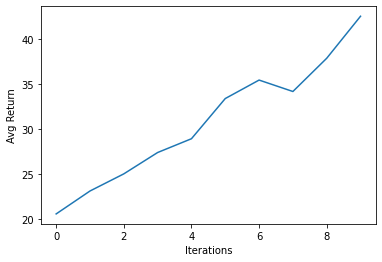

In [48]:
env_name = "CartPole-v0"
hidden_sizes = [32]
lr = 1e-2
epochs = 10
batch_size = 5000
render = False

env = gnwrapper.Animation(gym.make(env_name))
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

policy = mlp(sizes=[obs_dim] + hidden_sizes + [n_acts])
optimizer = keras.optimizers.Adam(learning_rate=lr)

params = {
    "env": env,
    "policy": policy,
    "optimizer": optimizer,
    "epochs": epochs,
    "batch_size": batch_size,
    "render": render,
}
agent = Reinforce(**params)
epoch_ret = agent.train(**params)

plotter = Plotter()
plotter.plot(epoch_ret)

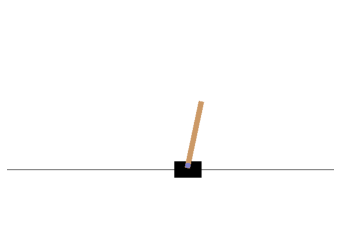

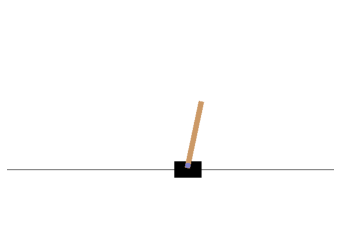

In [14]:
batch_size = 50
render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode(
    env, agent, batch_size, render
)

# Reward-to-Go Reinforce

In [15]:
class Reward_to_Go_Policy_Gradient(Reinforce):
    def __init__(self, **kwargs):
        super(Reward_to_Go_Policy_Gradient, self).__init__(**kwargs)

    def reward_to_go(self, rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i + 1] if i + 1 < n else 0)
        return rtgs

    def train_one_epoch(self, batch_size, render):
        batch_obs, batch_acts, batch_weights, batch_rets, batch_lens = (
            [],
            [],
            [],
            [],
            [],
        )

        obs = self.env.reset()
        done = False
        ep_rews = []

        finished_rendering_this_epoch = False

        while True:
            if (not finished_rendering_this_epoch) and render:
                self.env.render()

            batch_obs.append(obs.copy())

            act = self.get_action(obs.reshape(1, self.obs_dim)).numpy()[0]
            obs, rew, done, _ = self.env.step(act)

            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                batch_weights += list(self.reward_to_go(ep_rews))

                obs, done, ep_rews = self.env.reset(), False, []

                finished_rendering_this_epoch = True

                if len(batch_obs) > batch_size:
                    break

        batch_loss = self.apply_gradients(batch_obs, batch_acts, batch_weights)

        return batch_loss, batch_rets, batch_lens

epoch:   0 	 loss: 10.635 	 return: 24.325 	 ep_len: 24.325
epoch:   1 	 loss: 12.869 	 return: 27.571 	 ep_len: 27.571
epoch:   2 	 loss: 15.578 	 return: 34.764 	 ep_len: 34.764
epoch:   3 	 loss: 14.641 	 return: 33.892 	 ep_len: 33.892
epoch:   4 	 loss: 18.622 	 return: 39.480 	 ep_len: 39.480
epoch:   5 	 loss: 18.531 	 return: 46.083 	 ep_len: 46.083
epoch:   6 	 loss: 20.073 	 return: 49.614 	 ep_len: 49.614
epoch:   7 	 loss: 24.375 	 return: 59.786 	 ep_len: 59.786
epoch:   8 	 loss: 23.489 	 return: 57.705 	 ep_len: 57.705
epoch:   9 	 loss: 20.001 	 return: 55.033 	 ep_len: 55.033
epoch:  10 	 loss: 21.271 	 return: 55.407 	 ep_len: 55.407
epoch:  11 	 loss: 25.266 	 return: 67.595 	 ep_len: 67.595
epoch:  12 	 loss: 22.114 	 return: 61.815 	 ep_len: 61.815
epoch:  13 	 loss: 30.066 	 return: 83.733 	 ep_len: 83.733
epoch:  14 	 loss: 30.864 	 return: 79.444 	 ep_len: 79.444
epoch:  15 	 loss: 32.642 	 return: 88.228 	 ep_len: 88.228
epoch:  16 	 loss: 35.599 	 return: 98.8

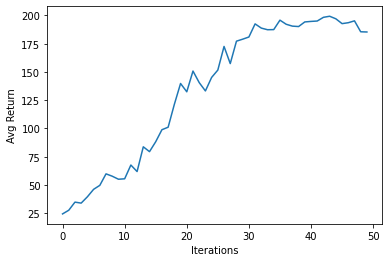

In [16]:
env_name = "CartPole-v0"
hidden_sizes = [32]
lr = 1e-2
epochs = 50
batch_size = 5000
render = False

env = gnwrapper.Animation(gym.make(env_name))
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

policy = mlp(sizes=[obs_dim] + hidden_sizes + [n_acts])
optimizer = keras.optimizers.Adam(learning_rate=lr)

params = {
    "env": env,
    "policy": policy,
    "optimizer": optimizer,
    "epochs": epochs,
    "batch_size": batch_size,
    "render": render,
}
agent = Reward_to_Go_Policy_Gradient(**params)
epoch_ret = agent.train(**params)

plotter = Plotter()
plotter.plot(epoch_ret)

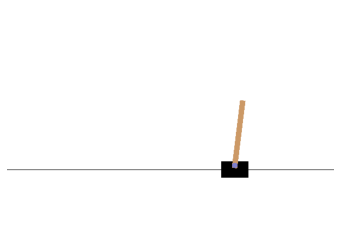

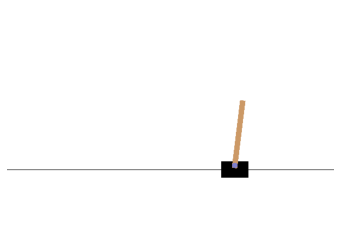

In [17]:
batch_size = 50000
render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode(
    env, agent, batch_size, render
)

# Behaviour Clone

In [19]:
class BC(BCAgent):
    def __init__(self, env, policy, optimizer, **kwargs):
        self.env = env
        assert isinstance(
            env.observation_space, Box
        ), "This example only works for envs with continuous state spaces."
        assert isinstance(
            env.action_space, Discrete
        ), "This example only works for envs with discrete action spaces."
        self.obs_dim = env.observation_space.shape[0]
        self.n_acts = env.action_space.n

        self.policy = policy
        self.optimizer = optimizer

    def get_policy(self, obs):
        """ action distribution"""
        logits = self.policy(obs)
        return tfp.distributions.Categorical(logits=logits)

    def get_action(self, obs):
        """ sample from action distribution"""
        return self.get_policy(obs).sample()

    def compute_loss(self, obs, act):
        bc_logits = self.policy(obs)

        def loss(act, bc_logits):
            return tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=act, logits=bc_logits
            )

        losses = tf.nest.map_structure(loss, act, bc_logits)
        losses = tf.nest.flatten(losses)
        return tf.reduce_mean(losses)

    def apply_gradients(self, batch_obs, batch_acts):
        with tf.GradientTape() as tape:
            batch_loss = self.compute_loss(
                obs=tf.convert_to_tensor(batch_obs, dtype=tf.float32),
                act=tf.convert_to_tensor(batch_acts, dtype=tf.int32),
            )

        self.apply_loss(
            losses=batch_loss,
            variable_to_train=self.policy.trainable_weights,
            tape=tape,
            optimizer=self.optimizer,
        )
        return batch_loss

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def pretrain(self, dataset, n_epochs=10, n_episodes=50, batch_size=1024, **kwargs):
        for epoch_idx in range(int(n_epochs)):
            train_loss = 0.0

            for _ in range(n_episodes):
                expert_exp = dataset.next_batch(batch_size)
                expert_obs, expert_acts = expert_exp["obs"], expert_exp["acts"]
                train_loss_ = self.apply_gradients(expert_obs, expert_acts)
                train_loss += train_loss_

            train_loss /= batch_size * n_episodes
            print(
                "==== Training progress {:.2f}% ====".format(
                    100 * (epoch_idx + 1) / n_epochs
                )
            )
            print("Epoch {}".format(epoch_idx + 1))
            print("Training loss {:.6f}".format(train_loss))
        print("Pretraining done.")

In [20]:
dataset = Dataset({"obs": np.array(batch_obs), "acts": np.array(batch_acts)})

env_name = "CartPole-v0"
hidden_sizes = [32]
lr = 1e-2
epochs = 50
batch_size = 1024
render = False

env = gnwrapper.Animation(gym.make(env_name))
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

policy = mlp(sizes=[obs_dim] + hidden_sizes + [n_acts])
optimizer = keras.optimizers.Adam(learning_rate=lr)

params = {
    "dataset": dataset,
    "env": env,
    "policy": policy,
    "optimizer": optimizer,
    "n_epochs": epochs,
    "batch_size": batch_size,
}
bc_agent = BC(**params)
bc_agent.pretrain(**params)

==== Training progress 2.00% ====
Epoch 1
Training loss 0.000568
==== Training progress 4.00% ====
Epoch 2
Training loss 0.000533
==== Training progress 6.00% ====
Epoch 3
Training loss 0.000532
==== Training progress 8.00% ====
Epoch 4
Training loss 0.000533
==== Training progress 10.00% ====
Epoch 5
Training loss 0.000533
==== Training progress 12.00% ====
Epoch 6
Training loss 0.000532
==== Training progress 14.00% ====
Epoch 7
Training loss 0.000532
==== Training progress 16.00% ====
Epoch 8
Training loss 0.000533
==== Training progress 18.00% ====
Epoch 9
Training loss 0.000532
==== Training progress 20.00% ====
Epoch 10
Training loss 0.000533
==== Training progress 22.00% ====
Epoch 11
Training loss 0.000532
==== Training progress 24.00% ====
Epoch 12
Training loss 0.000533
==== Training progress 26.00% ====
Epoch 13
Training loss 0.000530
==== Training progress 28.00% ====
Epoch 14
Training loss 0.000532
==== Training progress 30.00% ====
Epoch 15
Training loss 0.000534
==== Tra

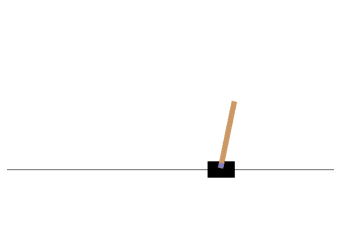

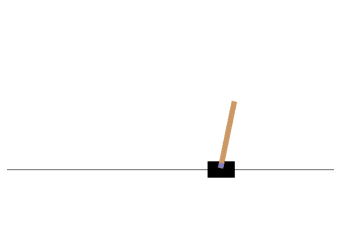

In [21]:
batch_size = 500
render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode(
    env, bc_agent, batch_size, render
)

# Vanilla Policy Gradient

In [108]:
class VPG(Agent):
    def __init__(self, env, actor_critic, optimizer, **kwargs):
        self.env = env
        assert isinstance(
            env.observation_space, Box
        ), "This example only works for envs with continuous state spaces."
        assert isinstance(
            env.action_space, Discrete
        ), "This example only works for envs with discrete action spaces."
        self.obs_dim = env.observation_space.shape[0]
        self.n_acts = env.action_space.n

        self.ac = actor_critic
        self.optimizer = optimizer

    def get_policy(self, obs):
        """ action distribution"""
        logits = self.ac.pi.nn(obs)
        return tfp.distributions.Categorical(logits=logits)

    def get_action(self, obs):
        """ sample from action distribution"""
        return self.get_policy(obs).sample()

    def advantage_fn(self, returns, value_preds):
        return returns - value_preds

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def compute_policy_loss(self, obs, acts, weights):
        logp = self.get_policy(obs).log_prob(acts)
        loss = -(logp * weights)
        return tf.math.reduce_mean(loss)

    def compute_critic_loss(self, preds, weights):
        loss = tf.math.squared_difference(weights, preds)
        return tf.math.reduce_mean(loss)

    def apply_policy_gradients(self, obs, acts, score):
        with tf.GradientTape() as tape:
            batch_loss = self.compute_policy_loss(obs=obs, acts=acts, weights=score)
        self.apply_loss(
            losses=batch_loss,
            variable_to_train=self.ac.pi.nn.trainable_weights,
            tape=tape,
            optimizer=self.optimizer,
        )
        return batch_loss

    def apply_critic_gradients(self, obs, returns):
        with tf.GradientTape() as tape:
            value_preds = self.ac.v.nn(obs)
            batch_loss = self.compute_critic_loss(preds=value_preds, weights=returns)
        self.apply_loss(
            losses=batch_loss,
            variable_to_train=self.ac.v.nn.trainable_weights,
            tape=tape,
            optimizer=self.optimizer,
        )
        return batch_loss

    def apply_gradients(self, obs, acts, returns):
        obs = tf.convert_to_tensor(obs, dtype=tf.float32)
        acts = tf.convert_to_tensor(acts, dtype=tf.int32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        value_preds = self.ac.v.nn(obs)
        advantages = self.advantage_fn(returns, value_preds)

        policy_loss = self.apply_policy_gradients(obs, acts, advantages)
        critic_loss = self.apply_critic_gradients(obs, returns)
        return policy_loss, critic_loss

    def reward_to_go(self, rews):
        n = len(rews)
        rtgs = np.zeros_like(rews)
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i + 1] if i + 1 < n else 0)
        return rtgs

    def train_one_epoch(self, batch_size, render):
        batch_obs, batch_acts, batch_weights, batch_rets, batch_lens = (
            [],
            [],
            [],
            [],
            [],
        )

        obs = self.env.reset()
        done = False
        ep_rews = []

        finished_rendering_this_epoch = False

        while True:
            if (not finished_rendering_this_epoch) and render:
                self.env.render()

            batch_obs.append(obs.copy())

            act = self.get_action(obs.reshape(1, self.obs_dim)).numpy()[0]
            obs, rew, done, _ = self.env.step(act)

            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                batch_weights += list(self.reward_to_go(ep_rews))

                obs, done, ep_rews = self.env.reset(), False, []

                finished_rendering_this_epoch = True

                if len(batch_obs) > batch_size:
                    break

        policy_loss, critic_loss = self.apply_gradients(
            batch_obs, batch_acts, batch_weights
        )

        return policy_loss, critic_loss, batch_rets, batch_lens, batch_obs, batch_acts

    def train(self, epochs, batch_size, render, **kwargs):
        epoch_ret = []
        for i in range(epochs):
            (
                policy_loss,
                critic_loss,
                batch_rets,
                batch_lens,
                batch_obs,
                batch_acts,
            ) = self.train_one_epoch(batch_size, render)
            epoch_ret.append(np.mean(batch_rets))
            print(
                "epoch: %3d \t policy_loss: %.3f \t critic_loss: %.3f \t return: %.3f \t ep_len: %.3f"
                % (
                    i,
                    policy_loss,
                    critic_loss,
                    np.mean(batch_rets),
                    np.mean(batch_lens),
                )
            )

        return epoch_ret, batch_obs, batch_acts

epoch:   0 	 policy_loss: 10.204 	 critic_loss: 352.272 	 return: 22.196 	 ep_len: 22.196
epoch:   1 	 policy_loss: 13.361 	 critic_loss: 674.613 	 return: 30.727 	 ep_len: 30.727
epoch:   2 	 policy_loss: 14.669 	 critic_loss: 792.533 	 return: 36.379 	 ep_len: 36.379
epoch:   3 	 policy_loss: 20.576 	 critic_loss: 1813.566 	 return: 46.000 	 ep_len: 46.000
epoch:   4 	 policy_loss: 20.312 	 critic_loss: 1792.061 	 return: 57.444 	 ep_len: 57.444


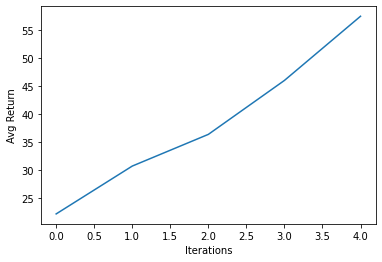

In [109]:
env_name = "CartPole-v0"
hidden_sizes = [32]
lr = 1e-2
epochs = 5
batch_size = 1000
render = False

env = gnwrapper.Animation(gym.make(env_name))
obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

actor_critic = MLPActorCritic(env.observation_space, env.action_space)
optimizer = keras.optimizers.Adam(learning_rate=lr)

params = {
    "env": env,
    "actor_critic": actor_critic,
    "optimizer": optimizer,
    "epochs": epochs,
    "batch_size": batch_size,
    "render": render,
}
VPG_agent = VPG(**params)
epoch_ret, batch_obs, batch_acts = VPG_agent.train(**params)

plotter = Plotter()
plotter.plot(epoch_ret)

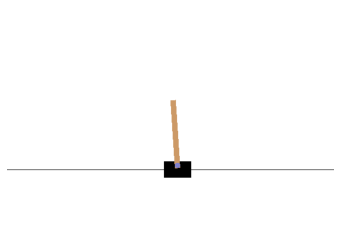

KeyboardInterrupt: 

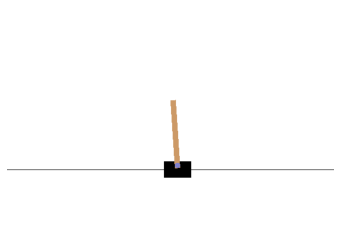

In [24]:
batch_size = 50000
render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode(
    env, VPG_agent, batch_size, render
)

# Proximal Policy Optimization

In [227]:
class PPOBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(Util.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)

        # GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = Util.discount_cumsum(deltas, self.gamma * self.lam)

        # rewards-to-go, targets for the value function
        self.ret_buf[path_slice] = Util.discount_cumsum(rews, self.gamma)[:-1]

        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size
        self.ptr, self.path_start_idx = 0, 0

        # advantage normalization trick
        adv_mean, adv_std = Util.statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        data = dict(
            obs=self.obs_buf,
            act=self.act_buf,
            ret=self.ret_buf,
            adv=self.adv_buf,
            logp=self.logp_buf,
        )
        return {k: tf.convert_to_tensor(v, dtype=tf.float32) for k, v in data.items()}

In [228]:
class PPO(Agent):
    def __init__(
        self,
        env,
        actor_critc=MLPActorCritic,
        ac_kwargs=dict(),
        seed=0,
        steps_per_epoch=4000,
        epochs=50,
        gamma=0.99,
        clip_ratio=0.2,
        pi_lr=3e-4,
        vf_lr=1e-3,
        train_pi_iters=80,
        train_v_iters=80,
        lam=0.97,
        max_ep_len=1000,
        target_kl=0.01,
        logger_kwargs=dict(),
        save_freq=10,
        **kwargs,
    ):
        self.env = env
        assert isinstance(
            env.observation_space, Box
        ), "This example only works for envs with continuous state spaces."
        assert isinstance(
            env.action_space, Discrete
        ), "This example only works for envs with discrete action spaces."

        self.obs_dim = env.observation_space.shape
        self.act_dim = env.action_space.shape

        self.ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
        self.pi_optimizer = keras.optimizers.Adam(learning_rate=pi_lr)
        self.v_optimizer = keras.optimizers.Adam(learning_rate=vf_lr)

        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch
        self.max_ep_len = max_ep_len

        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl

        self.buf = PPOBuffer(self.obs_dim, self.act_dim, steps_per_epoch, gamma, lam)

    def compute_loss_pi(self, data):
        obs, act, adv, logp_old = (
            data["obs"],
            data["act"],
            data["adv"],
            data["logp"],
        )
        pi, logp = self.ac.pi(obs, act)
        ratio = tf.exp(logp - logp_old)
        clip_adv = (
            tf.clip_by_value(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        )
        loss_pi = tf.math.reduce_mean(-tf.minimum(ratio * adv, clip_adv))

        approx_kl = tf.math.reduce_mean((logp_old - logp))
        ent = "NotImplementedError"
        clipfrac = "NotImpementedError"
        pi_info = dict(kl=approx_kl)
        return loss_pi, pi_info

    def compute_loss_v(self, data):
        obs, ret = data["obs"], data["ret"]
        v = self.ac.v(obs)
        loss = tf.math.squared_difference(ret, v)
        return tf.reduce_mean(loss)

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def apply_pi_gradients(self, data):
        for i in range(self.train_pi_iters):
            with tf.GradientTape() as tape:
                loss_pi, pi_info = self.compute_loss_pi(data)

            kl = tf.reduce_mean(pi_info["kl"])
            if kl > 1.5 * self.target_kl:
                break

            self.apply_loss(
                losses=loss_pi,
                variable_to_train=self.ac.pi.nn.trainable_weights,
                tape=tape,
                optimizer=self.pi_optimizer,
            )

    def apply_v_gradients(self, data):
        for i in range(self.train_v_iters):
            with tf.GradientTape() as tape:
                loss_v = self.compute_loss_v(data)

            self.apply_loss(
                losses=loss_v,
                variable_to_train=self.ac.v.nn.trainable_weights,
                tape=tape,
                optimizer=self.v_optimizer,
            )

    def update(self):
        data = self.buf.get()
        self.apply_pi_gradients(data)
        self.apply_v_gradients(data)

    def train(self):
        epoch_ret = []
        o, ep_ret, ep_len = self.env.reset(), 0, 0
        for epoch in range(self.epochs):
            batch_ret, batch_len = [], []
            for t in range(self.steps_per_epoch):
                a, v, logp = self.ac.step(o.reshape(1, self.obs_dim[0]))

                next_o, r, d, _ = self.env.step(a)
                ep_ret += r
                ep_len += 1

                self.buf.store(o, a, r, v, logp)

                o = next_o

                timeout = ep_len == self.max_ep_len
                terminal = d or timeout
                epoch_ended = t == self.steps_per_epoch - 1
                if terminal or epoch_ended:
                    if epoch_ended and not (terminal):
                        print(
                            "Warning: trajectory cut off by epoch at %d steps."
                            % ep_len,
                            flush=True,
                        )
                    if timeout or epoch_ended:
                        _, v, _ = self.ac.step(o.reshape(1, self.obs_dim[0]))
                    else:
                        v = 0
                    self.buf.finish_path(v)

                    batch_ret.append(ep_ret)
                    batch_len.append(ep_len)

                    o, ep_ret, ep_len = self.env.reset(), 0, 0

            self.update()

            epoch_ret.append(np.mean(batch_ret))
            print(
                "epoch: %3d \t return: %.3f \t len: %.3f"
                % (epoch, np.mean(batch_ret), np.mean(batch_len))
            )

        return epoch_ret

64:9: F841 local variable 'ent' is assigned to but never used
INFO:pycodestyle:64:9: F841 local variable 'ent' is assigned to but never used
65:9: F841 local variable 'clipfrac' is assigned to but never used
INFO:pycodestyle:65:9: F841 local variable 'clipfrac' is assigned to but never used


epoch:   0 	 return: 21.739 	 len: 21.739
epoch:   1 	 return: 31.496 	 len: 31.496
epoch:   2 	 return: 54.795 	 len: 54.795
epoch:   3 	 return: 100.000 	 len: 100.000
epoch:   4 	 return: 148.148 	 len: 148.148
epoch:   5 	 return: 173.913 	 len: 173.913
epoch:   6 	 return: 181.818 	 len: 181.818
epoch:   7 	 return: 200.000 	 len: 200.000
epoch:   8 	 return: 200.000 	 len: 200.000
epoch:   9 	 return: 190.476 	 len: 190.476
epoch:  10 	 return: 200.000 	 len: 200.000
epoch:  11 	 return: 190.476 	 len: 190.476
epoch:  12 	 return: 200.000 	 len: 200.000
epoch:  13 	 return: 200.000 	 len: 200.000
epoch:  14 	 return: 200.000 	 len: 200.000
epoch:  15 	 return: 190.476 	 len: 190.476
epoch:  16 	 return: 190.476 	 len: 190.476
epoch:  17 	 return: 200.000 	 len: 200.000
epoch:  18 	 return: 200.000 	 len: 200.000
epoch:  19 	 return: 200.000 	 len: 200.000


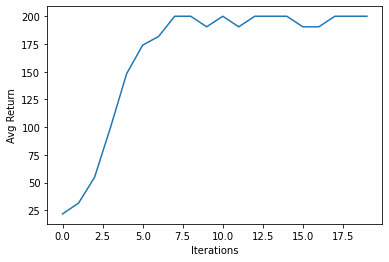

In [234]:
env_name = "CartPole-v0"
hidden_sizes = (512, 512)
ac_kwargs = {"hidden_sizes": hidden_sizes}
seed = 0
steps_per_epoch = 4000
epochs = 20
gamma = 0.99
clip_ratio = 0.2
pi_lr = 3e-4
vf_lr = 1e-3
train_pi_iters = 80
train_v_iters = 80
lam = 0.97
max_ep_len = 1000
target_kl = 0.01

render = False

env = gnwrapper.Animation(gym.make(env_name))
actor_critic = MLPActorCritic

params = {
    "env": env,
    "actor_critic": actor_critic,
    "ac_kwargs": ac_kwargs,
    "seed": seed,
    "steps_per_epoch": steps_per_epoch,
    "epochs": epochs,
    "gamma": gamma,
    "clip_ratio": clip_ratio,
    "pi_lr": pi_lr,
    "vf_lr": vf_lr,
    "train_pi_iters": train_pi_iters,
    "train_v_iters": train_v_iters,
    "lam": lam,
    "max_ep_len": max_ep_len,
    "target_kl": target_kl,
}
PPO_agent = PPO(**params)
epoch_ret = PPO_agent.train()

plotter = Plotter()
plotter.plot(epoch_ret)

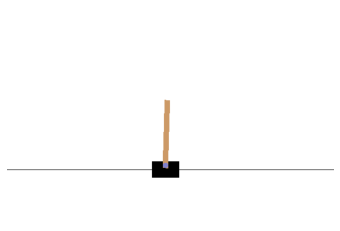

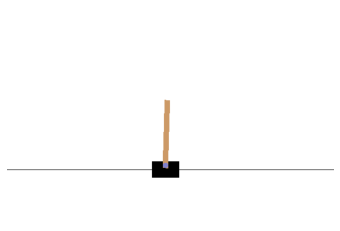

In [235]:
env = gnwrapper.Animation(gym.make(env_name))
batch_size = 50

render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode(
    env, PPO_agent, batch_size, render
)

# Deep Deterministic Policy Gradient

In [300]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(Util.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs=self.obs_buf[idxs],
            obs2=self.obs2_buf[idxs],
            act=self.act_buf[idxs],
            rew=self.rew_buf[idxs],
            done=self.done_buf[idxs],
        )
        return {k: tf.convert_to_tensor(v, dtype=tf.float32) for k, v in batch.items()}

In [301]:
class MLPActor(tf.keras.Model):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super(MLPActor, self).__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, tf.keras.activations.tanh)
        self.act_limit = act_limit

    def call(self, obs):
        return self.act_limit * self.pi(obs)


class MLPQFunction(tf.keras.Model):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super(MLPQFunction, self).__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def call(self, obs, act):
        obs_ = tf.concat([obs, act], axis=-1)
        q = self.q(obs_)
        return tf.squeeze(q, -1)


class MLPActorCritic(tf.keras.Model):
    def __init__(
        self,
        observation_space,
        action_space,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):
        super(MLPActorCritic, self).__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        return self.pi(obs).numpy()

In [302]:
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)
ac = MLPActorCritic(env.observation_space, env.action_space)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

obs = env.reset()
obs_ = tf.expand_dims(tf.convert_to_tensor(obs), axis=0)
print(f"obs: {obs}")

act = ac.act(obs_)[0]
act_ = tf.expand_dims(tf.convert_to_tensor(act), axis=0)
print(f"act: {act}")

act_call = ac.pi(obs_)[0]
print(f"act_call: {act_call}")

q = ac.q(obs_, act_)
print(f"q: {q}")

trainable_ac = ac.trainable
trainable_q = ac.q.trainable
trainable_pi = ac.pi.trainable
print(f"trainable ac:{trainable_ac}, q:{trainable_q}, pi:{trainable_pi}")
print(
    f"variable lens ac:{len(ac.variables)}, q:{len(ac.q.variables)}, pi:{len(ac.pi.variables)}"
)

obs: [-0.51568201  0.        ]
act: [-0.01697325]
act_call: [-0.01697325]
q: [-0.12405579]
trainable ac:True, q:True, pi:True
variable lens ac:12, q:6, pi:6


In [303]:
class DDPG:
    def __init__(
        self,
        env,
        actor_critic=MLPActorCritic,
        ac_kwargs=dict(),
        seed=0,
        steps_per_epoch=4000,
        epochs=100,
        replay_size=int(1e6),
        gamma=0.99,
        polyak=0.995,
        pi_lr=1e-3,
        q_lr=1e-3,
        batch_size=100,
        start_steps=10000,
        update_after=1000,
        update_every=50,
        act_noise=0.1,
        num_test_episodes=10,
        max_ep_len=1000,
        logger_kwargs=dict(),
        save_freq=1,
        *args,
        **kwargs,
    ):
        np.random.seed(seed)

        self.env, self.test_env = env, env
        self.obs_dim = env.observation_space.shape
        self.act_dim = env.action_space.shape[0]

        self.act_limit = env.action_space.high[0]

        self.ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
        self.ac_targ = actor_critic(
            env.observation_space, env.action_space, **ac_kwargs
        )

        self.pi_optimizer = keras.optimizers.Adam(learning_rate=pi_lr)
        self.q_optimizer = keras.optimizers.Adam(learning_rate=q_lr)

        self.ac_targ.trainable = False

        self.replay_buffer = ReplayBuffer(
            obs_dim=self.obs_dim, act_dim=self.act_dim, size=replay_size
        )

        self.writer = tf.summary.create_file_writer(**logger_kwargs)

        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.gamma = gamma
        self.polyak = polyak
        self.batch_size = batch_size
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.act_noise = act_noise
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len

        self.global_cnt = 0

    def compute_loss_q(self, data):
        o, a, r, o2, d = (
            data["obs"],
            data["act"],
            data["rew"],
            data["obs2"],
            data["done"],
        )
        q = self.ac.q(o, a)
        q_pi_targ = self.ac_targ.q(o2, self.ac_targ.pi(o2))
        backup = r + self.gamma * (1 - d) * q_pi_targ

        loss_q = tf.reduce_mean(tf.math.squared_difference(q, backup))

        loss_info = dict(QVals=q.numpy())

        tf.summary.scalar("Qloss", q.numpy().mean(), self.global_cnt)

        return loss_q, loss_info

    def compute_loss_pi(self, data):
        o = data["obs"]
        q_pi = self.ac.q(o, self.ac.pi(o))
        return -tf.reduce_mean(q_pi)

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def apply_q_gradients(self, data):
        with tf.GradientTape() as tape:
            loss_q, q_info = self.compute_loss_q(data)

        self.apply_loss(
            losses=loss_q,
            variable_to_train=self.ac.q.trainable_weights,
            tape=tape,
            optimizer=self.q_optimizer,
        )
        return loss_q

    def apply_pi_gradients(self, data):
        with tf.GradientTape() as tape:
            loss_pi = self.compute_loss_pi(data)

        self.apply_loss(
            losses=loss_pi,
            variable_to_train=self.ac.pi.trainable_weights,
            tape=tape,
            optimizer=self.pi_optimizer,
        )
        return loss_pi

    def update_fn(self, v1, v2, tau):
        v1 = tf.math.scalar_mul((1 - tau), v1)
        v2 = tf.math.scalar_mul(tau, v2)
        return tf.math.add(v1, v2)

    def soft_variable_update(self, source_var, target_var, tau=1.0):
        assert len(source_var) == len(
            target_var
        ), "target and source have different length"
        lens = len(source_var)
        for i in range(lens):
            target_var[i].assign(self.update_fn(target_var[i], source_var[i], tau))
        return target_var

    def update_target(self):
        self.soft_variable_update(
            self.ac.q.variables, self.ac_targ.q.variables, self.polyak
        )

        self.soft_variable_update(
            self.ac.pi.variables, self.ac_targ.pi.variables, self.polyak
        )

    def update(self, data):
        loss_q = self.apply_q_gradients(data)
        self.ac.q.trainable = False

        loss_pi = self.apply_pi_gradients(data)
        self.ac.q.trainable = True

        self.update_target()

        return loss_q, loss_pi

    def get_action(self, o, noise_scale):
        o_ = o.copy()
        o_ = tf.expand_dims(tf.convert_to_tensor(o_, dtype=tf.float32), axis=0)
        a = self.ac.act(o_)[0]
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)

    def train(self):
        self.writer.set_as_default()
        total_steps = self.steps_per_epoch * self.epochs
        start_time = time.time()
        o, ep_ret, ep_len = env.reset(), 0, 0
        batch_ret, epoch_ret = [], []

        for t in range(total_steps):
            self.global_cnt = t

            if t > self.start_steps:
                a = self.get_action(o, self.act_noise)
            else:
                a = self.env.action_space.sample()

            o2, r, d, _ = self.env.step(a)
            ep_ret += r
            ep_len += 1

            d = False if ep_len == max_ep_len else d

            self.replay_buffer.store(o, a, r, o2, d)

            o = o2

            if d or (ep_len == max_ep_len):
                batch_ret.append(ep_ret)
                o, ep_ret, ep_len = self.env.reset(), 0, 0

            if t >= update_after and t % update_every == 0:
                for _ in range(update_every):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    loss_q, loss_pi = self.update(data=batch)

            if (t + 1) % steps_per_epoch == 0:
                epoch = (t + 1) // self.steps_per_epoch

                epoch_ret.append(np.mean(batch_ret))
                print("epoch: %3d \t return: %.3f" % (epoch, np.mean(batch_ret)))
                batch_ret = []

        return epoch_ret

164:9: F841 local variable 'start_time' is assigned to but never used
INFO:pycodestyle:164:9: F841 local variable 'start_time' is assigned to but never used


epoch:   1 	 return: -174.529
epoch:   2 	 return: -105.972
epoch:   3 	 return: -399.338
epoch:   4 	 return: -681.202
epoch:   5 	 return: -405.176


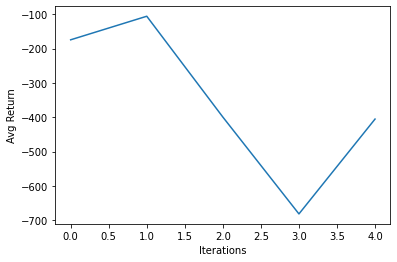

In [304]:
env_name = "LunarLanderContinuous-v2"
env = gnwrapper.Animation(gym.make(env_name))

actor_critic = MLPActorCritic
hidden_sizes = (512, 512)
ac_kwargs = {"hidden_sizes": hidden_sizes}

seed = 0
steps_per_epoch = 400  # 4000
epochs = 5
gamma = 0.99
pi_lr = 1e-3
q_lr = 1e-3
batch_size = 100
start_steps = 1000  # 10000
update_after = 100  # 1000
update_every = 50
act_noise = 0.1
num_test_episodes = 10
max_ep_len = 100  # 1000
logdir = "./tb/"
logger_kwargs = dict(logdir=logdir)
save_freq = 1
render = False

params = {
    "env": env,
    "actor_critic": actor_critic,
    "ac_kwargs": ac_kwargs,
    "seed": seed,
    "steps_per_epoch": steps_per_epoch,
    "epochs": epochs,
    "gamma": gamma,
    "pi_lr": pi_lr,
    "q_lr": q_lr,
    "batch_size": batch_size,
    "start_steps": start_steps,
    "update_after": update_after,
    "update_every": update_every,
    "act_noise": act_noise,
    "num_test_episodes": num_test_episodes,
    "max_ep_len": max_ep_len,
    "logger_kwargs": logger_kwargs,
    "save_freq": save_freq,
    "render": render,
}
DDPG_agent = DDPG(**params)
epoch_ret = DDPG_agent.train()

plotter = Plotter()
plotter.plot(epoch_ret)

In [305]:
%tensorboard --logdir '/home/yliu2/blimpRL/src/tb'

KeyboardInterrupt: 

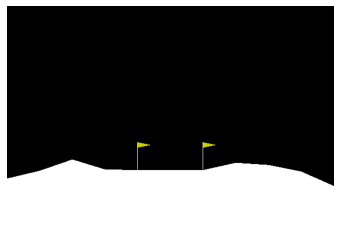

In [129]:
env = gnwrapper.Animation(gym.make(env_name))
batch_size = 1000

render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode_continuous(
    env, DDPG_agent, batch_size, render
)

# Twin Delayed DDPG

In [313]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(Util.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs=self.obs_buf[idxs],
            obs2=self.obs2_buf[idxs],
            act=self.act_buf[idxs],
            rew=self.rew_buf[idxs],
            done=self.done_buf[idxs],
        )
        return {k: tf.convert_to_tensor(v, dtype=tf.float32) for k, v in batch.items()}

In [335]:
class MLPActorCritic(tf.keras.Model):
    def __init__(
        self,
        observation_space,
        action_space,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):
        super(MLPActorCritic, self).__init__()
        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit)
        self.q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
        self.q2 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs):
        return self.pi(obs).numpy()[0]

In [359]:
class TD3:
    def __init__(
        self,
        env,
        actor_critic=MLPActorCritic,
        ac_kwargs=dict(),
        seed=0,
        steps_per_epoch=4000,
        epochs=100,
        replay_size=int(1e6),
        gamma=0.99,
        polyak=0.995,
        pi_lr=1e-3,
        q_lr=1e-3,
        batch_size=100,
        start_steps=10000,
        update_after=1000,
        update_every=50,
        act_noise=0.1,
        target_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
        num_test_episodes=10,
        max_ep_len=1000,
        logger_kwargs=dict(),
        save_freq=1,
        *args,
        **kwargs,
    ):
        np.random.seed(seed)

        self.env, self.test_env = env, env
        self.obs_dim = env.observation_space.shape
        self.act_dim = env.action_space.shape[0]

        self.act_limit = env.action_space.high[0]

        self.ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
        self.ac_targ = actor_critic(
            env.observation_space, env.action_space, **ac_kwargs
        )

        self.pi_optimizer = keras.optimizers.Adam(learning_rate=pi_lr)
        self.q_optimizer = keras.optimizers.Adam(learning_rate=q_lr)

        self.ac_targ.trainable = False

        self.replay_buffer = ReplayBuffer(
            obs_dim=self.obs_dim, act_dim=self.act_dim, size=replay_size
        )

        self.writer = tf.summary.create_file_writer(**logger_kwargs)
        self.global_cnt = 0

        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.gamma = gamma
        self.polyak = polyak
        self.batch_size = batch_size
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.act_noise = act_noise
        self.target_noise = target_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len

    def compute_loss_q(self, data):
        o, a, r, o2, d = (
            data["obs"],
            data["act"],
            data["rew"],
            data["obs2"],
            data["done"],
        )
        with tf.GradientTape(persistent=True) as tape:
            q1 = self.ac.q1(o, a)
            q2 = self.ac.q2(o, a)

            with tape.stop_recording():
                pi_targ = self.ac_targ.pi(o2)

                epsilon = tf.random.normal(pi_targ.shape) * self.target_noise
                epsilon = tf.clip_by_value(epsilon, -self.noise_clip, self.noise_clip)
                a2 = pi_targ + epsilon
                a2 = tf.clip_by_value(a2, -self.act_limit, self.act_limit)

                q1_pi_targ = self.ac_targ.q1(o2, a2)
                q2_pi_targ = self.ac_targ.q2(o2, a2)
                q_pi_targ = tf.minimum(q1_pi_targ, q2_pi_targ)
                backup = r + self.gamma * (1 - d) * q_pi_targ

            loss_q1 = tf.reduce_mean(tf.math.squared_difference(q1, backup))
            loss_q2 = tf.reduce_mean(tf.math.squared_difference(q2, backup))
            loss_q = loss_q1 + loss_q2

        tf.summary.scalar("ac.Q1.Vals", q1.numpy().mean(), self.global_cnt)
        tf.summary.scalar("ac.Q2.Vals", q2.numpy().mean(), self.global_cnt)

        return loss_q, tape

    def compute_loss_pi(self, data):
        o = data["obs"]
        with tf.GradientTape() as tape:
            q1_pi = self.ac.q1(o, self.ac.pi(o))
            loss_pi = -tf.reduce_mean(q1_pi)
        return loss_pi, tape

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def apply_q_gradients(self, data):
        loss_q, tape = self.compute_loss_q(data)

        self.apply_loss(
            losses=loss_q,
            variable_to_train=self.ac.q1.trainable_weights,
            tape=tape,
            optimizer=self.q_optimizer,
        )
        self.apply_loss(
            losses=loss_q,
            variable_to_train=self.ac.q2.trainable_weights,
            tape=tape,
            optimizer=self.q_optimizer,
        )

        tf.summary.scalar("loss_q", loss_q.numpy().mean(), self.global_cnt)

    def apply_pi_gradients(self, data):
        loss_pi, tape = self.compute_loss_pi(data)

        self.apply_loss(
            losses=loss_pi,
            variable_to_train=self.ac.pi.trainable_weights,
            tape=tape,
            optimizer=self.pi_optimizer,
        )

        tf.summary.scalar("loss_pi", loss_pi.numpy().mean(), self.global_cnt)

    def soft_variable_update(self, source_var, target_var, tau=1.0):
        def soft_update_fn(v1, v2, tau):
            v1 = tf.math.scalar_mul((1 - tau), v1)
            v2 = tf.math.scalar_mul(tau, v2)
            return tf.math.add(v1, v2)

        assert len(source_var) == len(
            target_var
        ), "target and source have different length"
        lens = len(source_var)
        for i in range(lens):
            target_var[i].assign(soft_update_fn(target_var[i], source_var[i], tau))

    def update(self, data, timer):
        self.apply_q_gradients(data)

        if timer % self.policy_delay == 0:
            self.ac.q1.trainable = False
            self.ac.q2.trainable = False

            self.apply_pi_gradients(data)

            self.ac.q1.trainable = True
            self.ac.q2.trainable = True

            # update ac_target
            self.soft_variable_update(
                self.ac.variables, self.ac_targ.variables, self.polyak
            )

    def get_action(self, o, noise_scale):
        o_ = o.copy()
        o_ = tf.expand_dims(tf.convert_to_tensor(o_, dtype=tf.float32), axis=0)
        a = self.ac.act(o_)
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)

    def train(self):
        self.writer.set_as_default()
        total_steps = self.steps_per_epoch * self.epochs
        start_time = time.time()
        o, ep_ret, ep_len = env.reset(), 0, 0
        batch_ret, epoch_ret = [], []

        for t in range(total_steps):
            self.global_cnt = t

            if t > self.start_steps:
                a = self.get_action(o, self.act_noise)
            else:
                a = self.env.action_space.sample()

            o2, r, d, _ = self.env.step(a)
            ep_ret += r
            ep_len += 1

            d = False if ep_len == max_ep_len else d

            self.replay_buffer.store(o, a, r, o2, d)

            o = o2

            if d or (ep_len == max_ep_len):
                batch_ret.append(ep_ret)
                tf.summary.scalar("return", ep_ret, self.global_cnt)
                
                o, ep_ret, ep_len = self.env.reset(), 0, 0

            if t >= update_after and t % update_every == 0:
                for j in range(update_every):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(data=batch, timer=j)

            if (t + 1) % steps_per_epoch == 0:
                epoch = (t + 1) // self.steps_per_epoch

                epoch_ret.append(np.mean(batch_ret))
                print("epoch: %3d \t return: %.3f" % (epoch, np.mean(batch_ret)))
                batch_ret = []


        return epoch_ret

187:9: F841 local variable 'start_time' is assigned to but never used
INFO:pycodestyle:187:9: F841 local variable 'start_time' is assigned to but never used


epoch:   1 	 return: -237.128


/home/yliu2/anaconda3/envs/blimpRL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yliu2/anaconda3/envs/blimpRL/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch:   2 	 return: -197.684
epoch:   3 	 return: -177.123
epoch:   4 	 return: -118.424
epoch:   5 	 return: -125.130
epoch:   6 	 return: -166.696
epoch:   7 	 return: 23.651
epoch:   8 	 return: -57.379
epoch:   9 	 return: 7.533
epoch:  10 	 return: -202.022
epoch:  11 	 return: -73.755
epoch:  12 	 return: -8.225
epoch:  13 	 return: 230.630
epoch:  14 	 return: 144.295
epoch:  15 	 return: 239.203
epoch:  16 	 return: 231.185
epoch:  17 	 return: 215.722
epoch:  18 	 return: 253.597
epoch:  19 	 return: 193.687
epoch:  20 	 return: 245.078


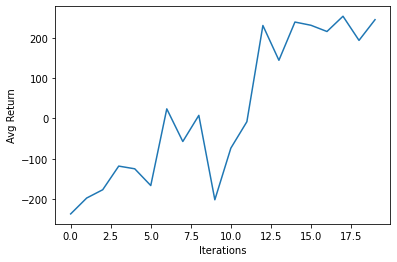

In [360]:
env_name = "LunarLanderContinuous-v2"
env = gnwrapper.Animation(gym.make(env_name))

actor_critic = MLPActorCritic
hidden_sizes = (512, 512)
ac_kwargs = {"hidden_sizes": hidden_sizes}

seed = 0
steps_per_epoch = 4000  # 4000
epochs = 20
gamma = 0.99
pi_lr = 1e-3
q_lr = 1e-3
batch_size = 100
start_steps = 10000  # 10000
update_after = 1000  # 1000
update_every = 50
act_noise = 0.1
target_noise = 0.2
noise_clip = 0.5
policy_delay = 2
num_test_episodes = 10
max_ep_len = 1000  # 1000
logdir = "./tb/td3"
logger_kwargs = dict(logdir=logdir)
save_freq = 1
render = False

params = {
    "env": env,
    "actor_critic": actor_critic,
    "ac_kwargs": ac_kwargs,
    "seed": seed,
    "steps_per_epoch": steps_per_epoch,
    "epochs": epochs,
    "gamma": gamma,
    "pi_lr": pi_lr,
    "q_lr": q_lr,
    "batch_size": batch_size,
    "start_steps": start_steps,
    "update_after": update_after,
    "update_every": update_every,
    "act_noise": act_noise,
    "target_noise": target_noise,
    "noise_clip": noise_clip,
    "policy_delay": policy_delay,
    "num_test_episodes": num_test_episodes,
    "max_ep_len": max_ep_len,
    "logger_kwargs": logger_kwargs,
    "save_freq": save_freq,
    "render": render,
}
TD3_agent = TD3(**params)
epoch_ret = TD3_agent.train()

plotter = Plotter()
plotter.plot(epoch_ret)

In [366]:
%tensorboard --logdir '/home/yliu2/blimpRL/src/tb/td3'

Reusing TensorBoard on port 6007 (pid 17749), started 0:28:38 ago. (Use '!kill 17749' to kill it.)

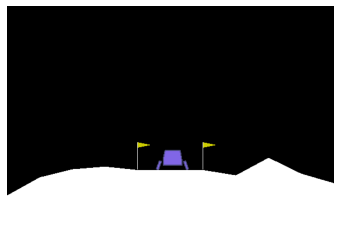

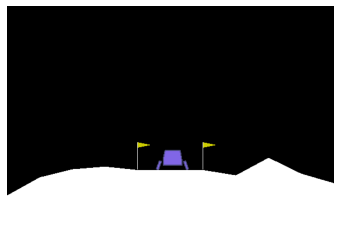

In [365]:
env = gnwrapper.Animation(gym.make(env_name))
batch_size = 100

render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode_continuous(
    env, DDPG_agent, batch_size, render
)

# Soft Actor Critic

In [98]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(Util.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(Util.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs=self.obs_buf[idxs],
            obs2=self.obs2_buf[idxs],
            act=self.act_buf[idxs],
            rew=self.rew_buf[idxs],
            done=self.done_buf[idxs],
        )
        return {k: tf.convert_to_tensor(v, dtype=tf.float32) for k, v in batch.items()}

In [133]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20


class SquashedGaussianMLPActor(tf.keras.Model):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super(SquashedGaussianMLPActor, self).__init__()
        self.net = mlp([obs_dim] + list(hidden_sizes), activation, activation)
        self.mu_layer = tf.keras.layers.Dense(act_dim)
        self.log_std_layer = tf.keras.layers.Dense(act_dim)
        self.act_limit = act_limit

    def call(self, obs, deterministic=False, with_logprob=True):
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        log_std = self.log_std_layer(net_out)
        log_std = tf.clip_by_value(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = tf.exp(log_std)

        pi_distribution = tfp.distributions.Normal(mu, std)
        if deterministic:
            pi_action = mu
        else:
            pi_action = pi_distribution.sample()  # rsample in pytorch?

        if with_logprob:
            logp_pi = tf.reduce_sum(pi_distribution.log_prob(pi_action), axis=-1)
            logp_pi -= tf.reduce_sum(
                2 * (np.log(2) - pi_action - tf.math.softplus(-2 * pi_action)), axis=1
            )
        else:
            logp_pi = None

        pi_action = tf.keras.activations.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi


class MLPQFunction(tf.keras.Model):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super(MLPQFunction, self).__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def call(self, obs, act):
        q = self.q(tf.concat([obs, act], axis=-1))
        return tf.squeeze(q, -1)


class MLPActorCritic(tf.keras.Model):
    def __init__(
        self,
        observation_space,
        action_space,
        hidden_sizes=(64, 64),
        activation=tf.keras.activations.relu,
    ):
        super(MLPActorCritic, self).__init__()
        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        self.pi = SquashedGaussianMLPActor(
            obs_dim, act_dim, hidden_sizes, activation, act_limit
        )
        self.q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
        self.q2 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)

    def act(self, obs, deterministic=False):
        a, _ = self.pi(obs, deterministic, False)
        return a.numpy()[0]

In [134]:
env_name = "LunarLanderContinuous-v2"
env = gnwrapper.Animation(gym.make(env_name))
obs = env.reset()
obs_ = tf.expand_dims(obs, axis=0)

ac = MLPActorCritic(env.observation_space, env.action_space)

act = ac.act(obs_)
print(f"act: {act}")

pi_action, logp_pi = ac.pi(obs_)
print(f"pi_action: {pi_action}")
print(f"logp_pi: {logp_pi}")

act_ = tf.expand_dims(act, axis=0)
value = ac.q1(obs_, act_)
print(f"value: {value}")

act: [-0.49553093 -0.9981711 ]
pi_action: [[ 0.646964 -0.352748]]
logp_pi: [-1.7315881]
value: [-0.4976436]


In [139]:
class SAC:
    def __init__(
        self,
        env,
        actor_critic=MLPActorCritic,
        ac_kwargs=dict(),
        seed=0,
        steps_per_epoch=4000,
        epochs=100,
        replay_size=int(1e6),
        gamma=0.99,
        polyak=0.995,
        lr=1e-3,
        alpha=0.2,
        batch_size=100,
        start_steps=10000,
        update_after=1000,
        update_every=50,
        num_test_episodes=10,
        max_ep_len=1000,
        logger_kwargs=dict(),
        save_freq=1,
        *args,
        **kwargs,
    ):
        np.random.seed(seed)

        self.env, self.test_env = env, env
        self.obs_dim = env.observation_space.shape
        self.act_dim = env.action_space.shape[0]

        self.act_limit = env.action_space.high[0]

        self.ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
        self.ac_targ = actor_critic(
            env.observation_space, env.action_space, **ac_kwargs
        )
        self.ac_targ.trainable = False

        self.pi_optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.q_optimizer = keras.optimizers.Adam(learning_rate=lr)

        self.replay_buffer = ReplayBuffer(
            obs_dim=self.obs_dim, act_dim=self.act_dim, size=replay_size
        )

        self.writer = tf.summary.create_file_writer(**logger_kwargs)
        self.global_cnt = 0

        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.gamma = gamma
        self.polyak = polyak
        self.alpha = alpha
        self.batch_size = batch_size
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len

    def compute_loss_q(self, data):
        o, a, r, o2, d = (
            data["obs"],
            data["act"],
            data["rew"],
            data["obs2"],
            data["done"],
        )
        with tf.GradientTape(persistent=True) as tape:
            q1 = self.ac.q1(o, a)
            q2 = self.ac.q2(o, a)

            with tape.stop_recording():
                a2, logp_a2 = self.ac.pi(o2)

                q1_pi_targ = self.ac_targ.q1(o2, a2)
                q2_pi_targ = self.ac_targ.q2(o2, a2)
                q_pi_targ = tf.minimum(q1_pi_targ, q2_pi_targ)
                backup = r + self.gamma * (1 - d) * (q_pi_targ - alpha * logp_a2)

            loss_q1 = tf.reduce_mean(tf.math.squared_difference(q1, backup))
            loss_q2 = tf.reduce_mean(tf.math.squared_difference(q2, backup))
            loss_q = loss_q1 + loss_q2

        with tf.name_scope("critic"):
            tf.summary.scalar("Q1.Vals", q1.numpy().mean(), self.global_cnt)
            tf.summary.scalar("Q2.Vals", q2.numpy().mean(), self.global_cnt)
            tf.summary.scalar("loss_q", loss_q.numpy().mean(), self.global_cnt)

        return loss_q, tape

    def compute_loss_pi(self, data):
        o = data["obs"]

        with tf.GradientTape() as tape:
            pi, logp_pi = self.ac.pi(o)
            q1_pi = self.ac.q1(o, pi)
            q2_pi = self.ac.q2(o, pi)
            q_pi = tf.minimum(q1_pi, q2_pi)

            loss_pi = tf.reduce_mean(alpha * logp_pi - q_pi)

        with tf.name_scope("actor"):
            tf.summary.scalar("LogPi", logp_pi.numpy().mean(), self.global_cnt)
            tf.summary.scalar("loss_pi", loss_pi.numpy().mean(), self.global_cnt)

        return loss_pi, tape

    def apply_loss(self, losses, variable_to_train, tape, optimizer):
        assert list(variable_to_train), "No variables in the agent's network."
        grads = tape.gradient(losses, variable_to_train)
        grads_and_vars = list(zip(grads, variable_to_train))
        optimizer.apply_gradients(grads_and_vars)

    def apply_q_gradients(self, data):
        loss_q, tape = self.compute_loss_q(data)

        self.apply_loss(
            losses=loss_q,
            variable_to_train=self.ac.q1.trainable_weights,
            tape=tape,
            optimizer=self.q_optimizer,
        )
        self.apply_loss(
            losses=loss_q,
            variable_to_train=self.ac.q2.trainable_weights,
            tape=tape,
            optimizer=self.q_optimizer,
        )

    def apply_pi_gradients(self, data):
        loss_pi, tape = self.compute_loss_pi(data)

        self.apply_loss(
            losses=loss_pi,
            variable_to_train=self.ac.pi.trainable_weights,
            tape=tape,
            optimizer=self.pi_optimizer,
        )

    def soft_variable_update(self, source_var, target_var, tau=1.0):
        def soft_update_fn(v1, v2, tau):
            v1 = tf.math.scalar_mul((1 - tau), v1)
            v2 = tf.math.scalar_mul(tau, v2)
            return tf.math.add(v1, v2)

        assert len(source_var) == len(
            target_var
        ), "target and source have different length"
        lens = len(source_var)
        for i in range(lens):
            target_var[i].assign(soft_update_fn(target_var[i], source_var[i], tau))

    def update(self, data):
        self.apply_q_gradients(data)

        self.ac.q1.trainable = False
        self.ac.q2.trainable = False

        self.apply_pi_gradients(data)

        self.ac.q1.trainable = True
        self.ac.q2.trainable = True

        # update ac_target
        self.soft_variable_update(
            self.ac.q1.variables, self.ac_targ.q1.variables, self.polyak
        )
        self.soft_variable_update(
            self.ac.q2.variables, self.ac_targ.q2.variables, self.polyak
        )

    def get_action(self, o, deterministic=False):
        o_ = tf.expand_dims(tf.convert_to_tensor(o, dtype=tf.float32), axis=0)
        a = self.ac.act(o_, deterministic)
        return a

    def train(self):
        self.writer.set_as_default()
        total_steps = self.steps_per_epoch * self.epochs
        start_time = time.time()
        o, ep_ret, ep_len = env.reset(), 0, 0
        batch_ret, epoch_ret = [], []

        for t in range(total_steps):
            self.global_cnt = t

            if t > self.start_steps:
                a = self.get_action(o)
            else:
                a = self.env.action_space.sample()

            o2, r, d, _ = self.env.step(a)
            ep_ret += r
            ep_len += 1

            d = False if ep_len == max_ep_len else d

            self.replay_buffer.store(o, a, r, o2, d)

            o = o2

            if d or (ep_len == max_ep_len):
                batch_ret.append(ep_ret)
                tf.summary.scalar("return", ep_ret, self.global_cnt)

                o, ep_ret, ep_len = self.env.reset(), 0, 0

            if t >= update_after and t % update_every == 0:
                for j in range(update_every):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(data=batch)

            if (t + 1) % steps_per_epoch == 0:
                epoch = (t + 1) // self.steps_per_epoch

                epoch_ret.append(np.mean(batch_ret))
                print("epoch: %3d \t return: %.3f" % (epoch, np.mean(batch_ret)))
                batch_ret = []

        return epoch_ret

182:9: F841 local variable 'start_time' is assigned to but never used
INFO:pycodestyle:182:9: F841 local variable 'start_time' is assigned to but never used


epoch:   1 	 return: -268.982
epoch:   2 	 return: -182.686
epoch:   3 	 return: -181.395
epoch:   4 	 return: 96.104
epoch:   5 	 return: 27.847
epoch:   6 	 return: 2.514
epoch:   7 	 return: 101.574
epoch:   8 	 return: -244.525
epoch:   9 	 return: -269.538
epoch:  10 	 return: 21.624
epoch:  11 	 return: 40.011
epoch:  12 	 return: 72.391
epoch:  13 	 return: 211.307
epoch:  14 	 return: 254.294
epoch:  15 	 return: 152.701
epoch:  16 	 return: 241.206
epoch:  17 	 return: 224.932
epoch:  18 	 return: 193.919
epoch:  19 	 return: 213.337
epoch:  20 	 return: 223.883


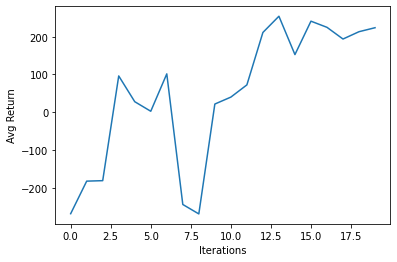

In [146]:
env_name = "LunarLanderContinuous-v2"
env = gnwrapper.Animation(gym.make(env_name))

actor_critic = MLPActorCritic
hidden_sizes = (512, 512)
ac_kwargs = {"hidden_sizes": hidden_sizes}

seed = 0
steps_per_epoch = 4000  # 4000
epochs = 20
gamma = 0.99
lr = 1e-3
alpha = 0.2
batch_size = 100
start_steps = 10000  # 10000
update_after = 1000  # 1000
update_every = 50
num_test_episodes = 10
max_ep_len = 1000  # 1000
logdir = "./tb/sac"
logger_kwargs = dict(logdir=logdir)
save_freq = 1
render = False

params = {
    "env": env,
    "actor_critic": actor_critic,
    "ac_kwargs": ac_kwargs,
    "seed": seed,
    "steps_per_epoch": steps_per_epoch,
    "epochs": epochs,
    "gamma": gamma,
    "lr": lr,
    "alpha": alpha,
    "batch_size": batch_size,
    "start_steps": start_steps,
    "update_after": update_after,
    "update_every": update_every,
    "num_test_episodes": num_test_episodes,
    "max_ep_len": max_ep_len,
    "logger_kwargs": logger_kwargs,
    "save_freq": save_freq,
    "render": render,
}
SAC_agent = SAC(**params)
epoch_ret = SAC_agent.train()

plotter = Plotter()
plotter.plot(epoch_ret)

In [147]:
%tensorboard --logdir '/home/yliu2/blimpRL/src/tb/sac'

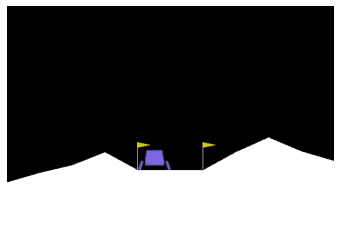

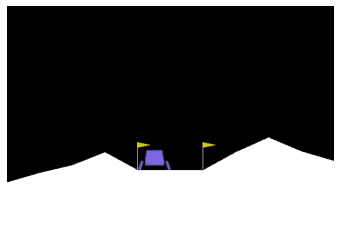

In [151]:
env = gnwrapper.Animation(gym.make(env_name))
batch_size = 200

render = True

clsRender = Render()
batch_obs, batch_acts, batch_weights = clsRender.play_one_episode_continuous(
    env, SAC_agent, batch_size, render
)